In [7]:

import torch
import torchtext
import torch.nn as nn
from torchtext import data
from torchtext import datasets
import torch.optim as optim
import time
import warnings
warnings.filterwarnings('ignore')

TEXT = data.Field(include_lengths=True)

# If you want to use English tokenizer from SpaCy, you need to install SpaCy and download its English model:
# pip install spacy
# python -m spacy download en_core_web_sm
# TEXT = data.Field(tokenize='spacy', tokenizer_language='en_core_web_sm', include_lengths=True)

LABEL = data.LabelField(dtype=torch.long)

train_data, valid_data, test_data = datasets.SST.splits(TEXT, LABEL, train_subtrees=True, filter_pred=lambda ex: ex.label != 'neutral')
print(len(train_data))
# TEXT.build_vocab(train_data)
# Here, you can also use some pre-trained embedding
TEXT.build_vocab(train_data,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data,
                 vectors="glove.6B.100d",
                 unk_init=torch.Tensor.normal_)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key=lambda x: len(x.text),
    batch_size=batch_size, 
    sort_within_batch=False,
    shuffle=True,
    device=device)


98794


In [8]:
for batch in train_iterator:
    sent, labels = batch.text, batch.label
    print(sent[0])
    
    break

tensor([[  75,  101,  748,  ...,  171,  610,  123],
        [ 743,   18,    5,  ...,   21,   12,    1],
        [ 735, 2284,    1,  ...,   20,    3,    1],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')


In [9]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class BiLSTM(nn.Module):

    def __init__(
        self, 
        embedding_dim, 
        hidden_dim, 
        vocab_size, 
        label_size, 
        batch_size
    ):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim, 
            hidden_size=hidden_dim, 
            bidirectional=True,
            
        )
        self.hidden2label = nn.Linear(hidden_dim*2, label_size)
        
        self.hidden = self.init_hidden()
        
        

    def init_hidden(self):
        # first is the hidden h
        # second is the cell c
        if torch.cuda.is_available():
            # print('use gpu')
            # print(self.device)
            return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim).cuda()),
                    Variable(torch.zeros(2, self.batch_size, self.hidden_dim).cuda()))
        else:
            # print('use cpu')
            # print(self.device)
            return (Variable(torch.zeros(2, self.batch_size, self.hidden_dim)),
                    Variable(torch.zeros(2, self.batch_size, self.hidden_dim)))

    def forward(self, sentence):
        # print(len(sentence))
        # print(self.batch_size)
        self.hidden = self.init_hidden()
        x = self.embeddings(sentence).view(len(sentence), self.batch_size, -1)
        
        # Detach hidden states from the graph
        # self.hidden = tuple(h.detach() for h in self.hidden)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        
        y = self.hidden2label(lstm_out[-1])
        
        log_probs = F.log_softmax(y)
        
        return log_probs

In [10]:

network = BiLSTM(
    embedding_dim=100,
    hidden_dim=150,
    vocab_size=len(TEXT.vocab),
    label_size=len(LABEL.vocab),
    batch_size=batch_size
)



In [11]:
print(len(TEXT.vocab))
print()

18003



In [5]:
print(network.embeddings)
print(len(train_iterator))
print(len(valid_iterator))
print(len(test_iterator))

Embedding(18003, 100)
1544
14
29


In [6]:
print(len(LABEL.vocab))
network.to(device=device)
print(network)

2
BiLSTM(
  (embeddings): Embedding(18003, 100)
  (lstm): LSTM(100, 150, bidirectional=True)
  (hidden2label): Linear(in_features=300, out_features=2, bias=True)
)


In [7]:
epoch_no = 20
learning_rate = 1e-2

loss_func = nn.CrossEntropyLoss()


In [8]:
for i, batch in enumerate(train_iterator):
    if len(batch) != batch_size:
        print(len(batch))
        
for i, batch in enumerate(valid_iterator):
    if len(batch) != batch_size:
        print(len(batch))
        
for i, batch in enumerate(test_iterator):
    if len(batch) != batch_size:
        print(len(batch))
        



42
40
29


In [9]:
import os
import sys


# learning_rate = [1.0, 0.1, 0.01, 0.001, 0.0001]
learning_rate = [1e-3, 1e-4, 1e-5, 1e-6]

for lr in learning_rate:
    # optimizer = optim.Adam(network.parameters(), lr=lr)
    optimizer = optim.SGD(network.parameters(), lr=lr, momentum=0.9) # weight_decay for regularization

    
    begin_time = time.time()
    logname = 'result_LSTM_'+ str(lr) + '.txt'

    if os.path.exists(logname):
        os.remove(logname)
    f = open(logname, 'w')
    f.write('Run Start Time: ' + str(time.ctime()))
    f.write('Learning Rate\t%f\n' % lr)

    for epoch in range(epoch_no):
        epoch_start_time = time.time()
        epoch_loss = 0.0
        
        # train
        for i, batch in enumerate(train_iterator):
            
            sent, labels = batch.text, batch.label
            
            lala = sent[0].to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # print(lala.shape)
            # print(labels.shape)
            network.batch_size = len(labels)
            network.hidden = network.init_hidden()
            
            outputs = network.forward(lala)
            batch_loss = loss_func(outputs, labels)
            
            batch_loss.backward()
            optimizer.step()
            
            epoch_loss += batch_loss.item()
            
        f.write("Epoch\t%d\tLoss\t%f\t" % (epoch + 1, epoch_loss / (i + 1)))
        epoch_end_time = time.time()
        
        # test
        with torch.no_grad():
            correct = 0
            total = 0
            
            for batch in test_iterator:
                sent, labels = batch.text, batch.label
                
                lala = sent[0].to(device)
                labels = labels.to(device)
                
                network.batch_size = len(labels)
                network.hidden = network.init_hidden()
                
                # Forward pass            
                outputs = network.forward(lala)
                
                # print(outputs)
                
                _, predicted = torch.max(outputs.data, 1)
                correct_matrix = (predicted == labels)
                
                correct = correct + correct_matrix.sum().item()
                total = total + len(correct_matrix)
                
                # sys.exit()

                
        f.write('Accuracy of the network [%d/%d]\t%f %%\n' % (correct, total, 100 * correct / total))
        print(f'Epoch:{epoch} Complete!')
        print(100 * correct / total)

    f.write('Training Complete: ' + str(time.ctime()) + '\n')
    run_time = time.time() - begin_time
    f.write('Runtime\t%f\n' % run_time)
    f.close()


Epoch:0 Complete!
49.86271279516749
Epoch:1 Complete!
49.86271279516749
Epoch:2 Complete!
49.86271279516749
Epoch:3 Complete!
49.86271279516749
Epoch:4 Complete!
49.91762767710049
Epoch:5 Complete!
49.91762767710049
Epoch:6 Complete!
49.91762767710049
Epoch:7 Complete!
50.0274574409665
Epoch:8 Complete!
50.08237232289951
Epoch:9 Complete!
49.86271279516749
Epoch:10 Complete!
50.08237232289951
Epoch:11 Complete!
50.521691378363535
Epoch:12 Complete!
50.08237232289951
Epoch:13 Complete!
50.13728720483251
Epoch:14 Complete!
50.30203185063152
Epoch:15 Complete!
51.23558484349259
Epoch:16 Complete!
67.49038989566172
Epoch:17 Complete!
77.64964305326744
Epoch:18 Complete!
77.75947281713344
Epoch:19 Complete!
56.39758374519495
Epoch:0 Complete!
54.310818231740804
Epoch:1 Complete!
52.8830313014827
Epoch:2 Complete!
55.07962657880285
Epoch:3 Complete!
54.475562877539815
Epoch:4 Complete!
55.24437122460187
Epoch:5 Complete!
56.891817682591984
Epoch:6 Complete!
55.95826468973092
Epoch:7 Complete

In [2]:
import re
import matplotlib.pyplot as plt
import numpy as np

namehere = 'result_LSTM'
# Open the file and read its content
with open(namehere+'.txt', 'r') as file:
    content = file.read()

# Use regular expressions to find loss and accuracy values
loss_pattern = re.compile(r'Epoch\s*\d+\s*Loss\s*([\d.]+)')
accuracy_pattern = re.compile(r'Accuracy of the network \[([\d]+)/\d+\]\s*([\d.]+)')

# Find all occurrences of loss and accuracy in the content
loss_values = [float(match.group(1)) for match in loss_pattern.finditer(content)]
accuracy_values = [float(match.group(2)) for match in accuracy_pattern.finditer(content)]

# Print the extracted values
print("Loss values:", loss_values)
print("Accuracy values:", accuracy_values)

Loss values: [0.554752, 0.26927, 0.168324, 0.116975, 0.086841, 0.066177, 0.052417, 0.040707, 0.034912, 0.029468, 0.026445, 0.022692, 0.020196, 0.018369, 0.01749, 0.015653, 0.013143, 0.012518, 0.014725, 0.011003]
Accuracy values: [75.892367, 80.395387, 79.516749, 81.109281, 81.878089, 81.878089, 80.779791, 81.658429, 81.164195, 81.5486, 82.317408, 81.658429, 80.230643, 80.175728, 80.615047, 80.779791, 80.615047, 81.768259, 79.461834, 81.823174]


/tmp/ipykernel_11284/1657394106.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bD" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x,loss_values, '-bD',  c='blue', mfc='red', mec='k')


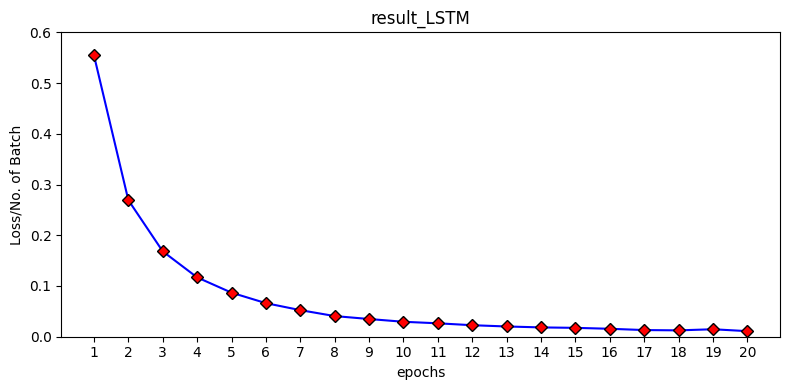

In [4]:

filename = namehere + ".pdf"

plt.rcParams["figure.figsize"] = [8.0,4.0]
plt.rcParams["figure.autolayout"] = True
plt.title(namehere)

x = list(range(1,21)) 
plt.plot(x,loss_values, '-bD',  c='blue', mfc='red', mec='k')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("epochs", )
plt.ylabel("Loss/No. of Batch")
plt.ylim(0.0,0.6)
plt.savefig("./" + filename, format="pdf", bbox_inches="tight")
plt.show()

/tmp/ipykernel_11284/2087440392.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-bD" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, accuracy_values, '-bD',  c='blue', mfc='red', mec='k')


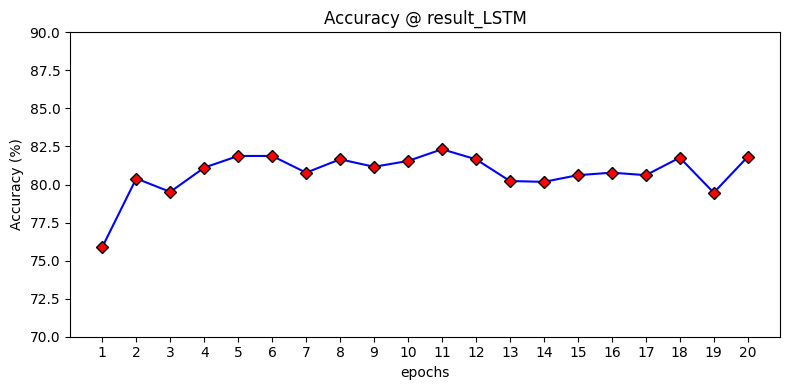

In [6]:
filename = namehere + "_accuracy" + ".pdf"

plt.rcParams["figure.figsize"] = [8.0,4.0]
plt.rcParams["figure.autolayout"] = True
plt.title("Accuracy @ " + namehere)

x = list(range(1,21))
plt.plot(x, accuracy_values, '-bD',  c='blue', mfc='red', mec='k')
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("epochs", )
plt.ylabel("Accuracy (%)")
plt.ylim(70, 90)
plt.savefig("./" + filename, format="pdf", bbox_inches="tight")
plt.show()